In [1]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
import os
import shutil

/home/robin/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [44]:
# Access pickle file
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Get model output from pickle file
s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [46]:
# Load zdata
zdata = pandas.read_csv('zdata - with lobar volumes (without duplicates).csv')

In [47]:
#zdata.ml_subtype.value_counts()
zdata.ml_stage.value_counts()

ml_stage
0.0     378
5.0      47
1.0      45
3.0      37
7.0      30
6.0      29
4.0      26
8.0      23
2.0      19
9.0       8
10.0      3
11.0      3
12.0      2
13.0      1
14.0      1
Name: count, dtype: int64

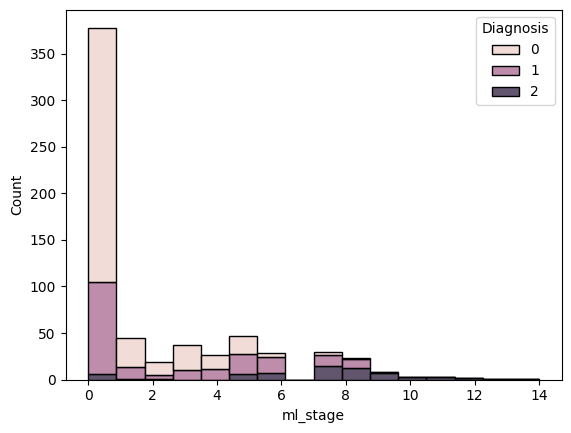

In [48]:
# Use clincial diagnostic categories as a rough way to assess the sucess of the model's stage assignments

#sns.displot(x='ml_stage',hue='Diagnosis',data=zdata)

sns.histplot(data=zdata, x='ml_stage', hue='Diagnosis', multiple='stack')
plt.show()

# Trajectory plots for each biomarker

In [51]:
# store our biomarker labels as a variable
biomarkers = zdata.columns[4:10]
print(biomarkers)

Index(['W_average_hippo', 'W_ADAS11', 'W_average_tau', 'W_Average_frontal',
       'W_Average_temporal', 'W_Average_parietal'],
      dtype='object')


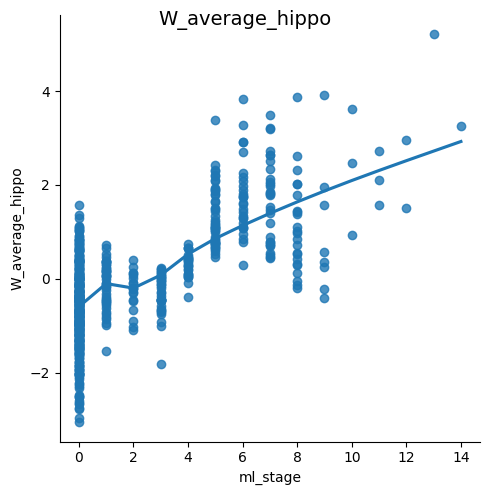

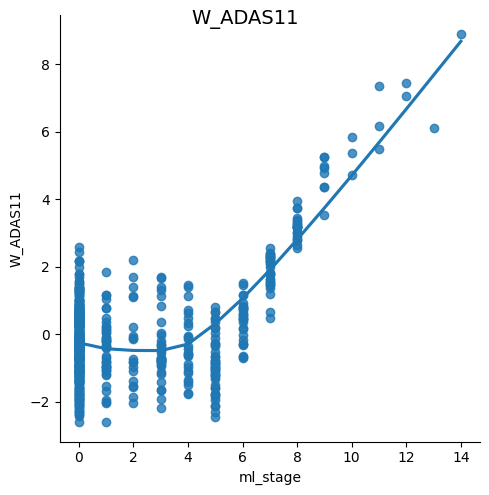

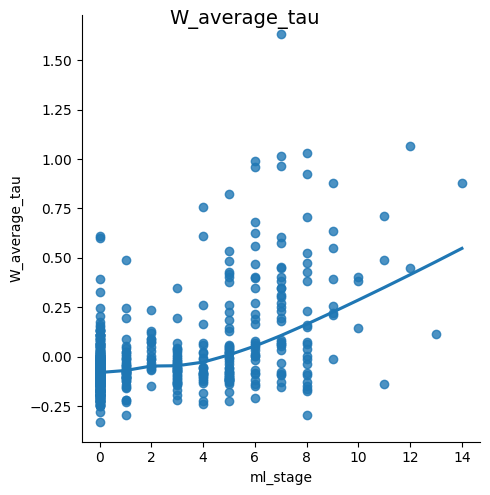

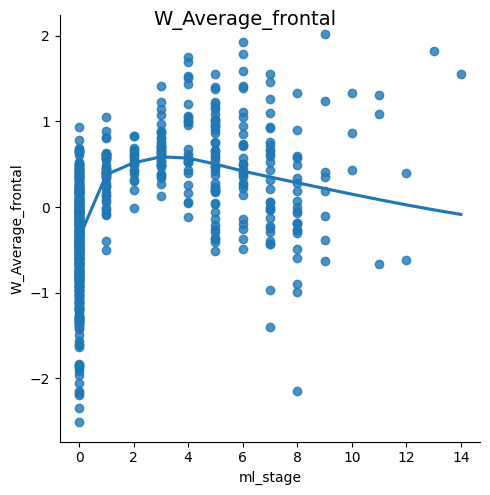

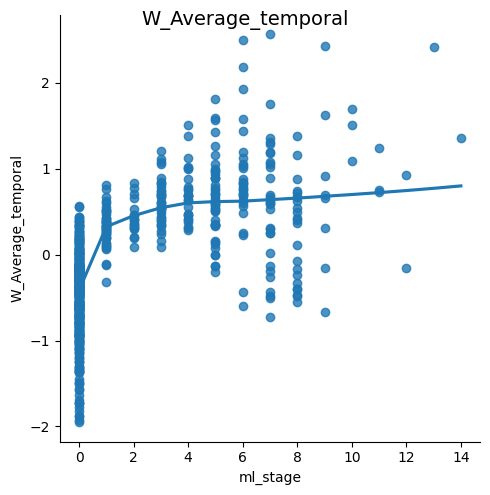

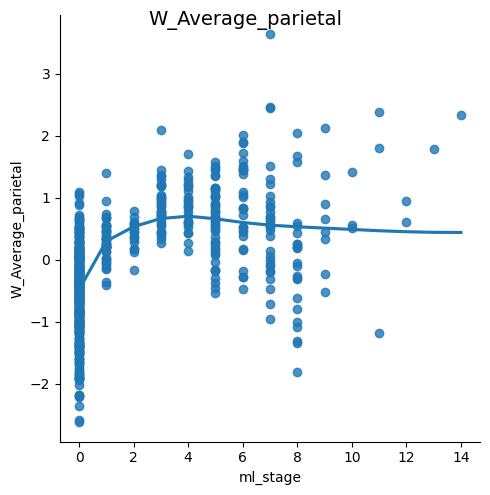

In [52]:
# Compare these plots to known biomarker trajectories for AD to validate model output

for biomarker in biomarkers:
    
    var = biomarker

    # plot relationship between each biomarker and stage for each subject
    sns.lmplot(x='ml_stage',y=var,
          data = zdata,
           lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          ) 

    # Add a title to the plot
    plt.gcf().suptitle(biomarker, fontsize=14) 

    plt.show()

# Calculate y_k at each stage for a biomarker
Can use this code for any biomarker, including tau regional values and functional metrics

In [53]:
# Load data for biomarker of interest (in this case tau regional data)
tau_data = pandas.read_csv('Cog_Tau_V1.csv')
tau_data

,Unnamed: 0,merge_RID,MMSE_bl,ADAS11_bl,ADAS13_bl,merge_DX,best_DX,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
0,0,21,30,6.67,9.67,CN,CN,1.2475,1.0892,1.0955,...,1.3654,1.0367,1.4502,1.2605,1.5012,1.6893,1.5871,1.2446,1.3873,1.3700
1,1,31,30,1.67,1.67,CN,CN,1.1139,1.1076,1.0328,...,1.1874,1.0214,1.1399,1.0789,1.4155,1.6119,1.3522,1.2963,1.2469,1.2306
2,2,31,30,1.67,1.67,CN,CN,1.0569,1.0586,1.0009,...,1.1836,1.0075,1.0777,0.9884,1.3432,1.5118,1.3250,1.3075,1.1791,1.1674
3,3,56,28,3.00,3.00,MCI,EMCI,1.2538,1.1106,1.1190,...,1.3716,1.0188,1.3359,1.2523,1.6850,1.8019,1.3568,1.2301,1.2582,1.3548
4,4,56,28,3.00,3.00,MCI,EMCI,1.2577,1.1456,1.1177,...,1.4087,0.9860,1.3640,1.2448,1.6487,1.8489,1.3794,1.2615,1.2479,1.3791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,814,6704,28,10.33,14.33,CN,SMC,1.2162,1.0774,1.0614,...,1.2594,0.9930,1.1802,1.1326,1.4175,1.5608,1.1500,1.1447,1.1515,1.2648
815,815,6705,25,19.33,27.33,Dementia,AD,1.1079,0.9254,0.9342,...,1.1246,0.9868,1.1477,1.0165,1.4472,1.4985,1.1016,1.1784,1.1304,1.1523
816,816,6713,27,19.00,29.00,Dementia,AD,1.0330,0.8888,0.9048,...,1.1295,1.0018,1.0457,0.9666,1.2911,1.3663,1.3025,1.5126,1.1515,1.1213
817,817,6721,25,19.67,29.67,Dementia,AD,1.2617,1.1233,1.0587,...,1.3737,0.9982,1.4278,1.2245,1.6813,1.9355,1.3154,1.3254,1.4672,1.4012


In [54]:
# Delete RIDs with NaN values in any column 

value_to_drop = [4513, 6038, 6505, 6598]  
    
# Drop rows where 'RID' matches any value in 'value_to_drop'
tau_data = tau_data[~tau_data['merge_RID'].isin(value_to_drop)]

# Delete redundant RIDs
tau_data = tau_data.drop_duplicates(subset='merge_RID', keep='first')

In [63]:
# Create a data frame for the stage probability distributions for each subject from pickle file
prob_stage = pandas.DataFrame(pk['prob_stage'])

# Define the number of stages 
stage_count = prob_stage.shape[1]
    
# Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
biomarker_of_interest = 'Right-Amygdala' # INPUT BIOMARKER OF INTEREST HERE exactly as it appears in column title   
biomarker_data = tau_data[biomarker_of_interest]

In [64]:
# Initialize list of y(k) values for each stage k
biomarker_values = []

for k in range(int(stage_count)): # For each stage k
    sum = 0 # Define a variable for sum of all subjects i (numerator)

    
    for i in range(len(biomarker_data)): # For each subject i 
        
        prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k
        value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
        product = prob * value # Multiply 
        sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

    column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator)

    final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
    biomarker_values.append(final_value) # Save sum to biomarker_values list

# Print list of y(k) values (each value in list corresponds to a stage k)
print(biomarker_values)

[1.193279913339483, 1.2001291056631893, 1.2079876636838192, 1.2152171421837599, 1.236812370027779, 1.2916194934946241, 1.417020290557514, 1.5185637766974995, 1.4418464607654955, 1.4708390277864805, 1.5219624099841245, 1.5439259654690334, 1.5715393495326617, 1.6137271404742841, 1.6482809703150234, 1.66066909556968, 1.663775525100231, 1.6646233619273407, 1.6649135042152292]


# Gaussian Interpolation 
Create and plot a continuous time series from discrete y_k values for biomarker of interest

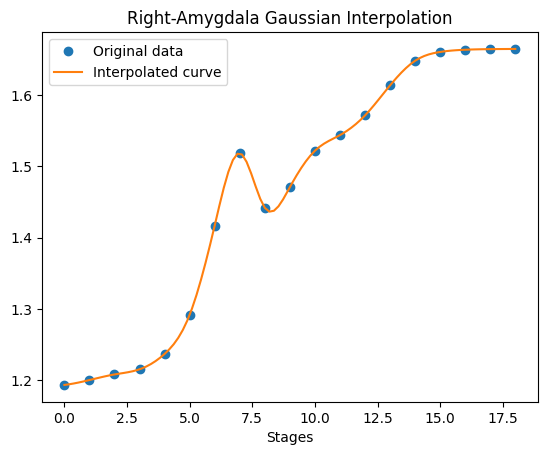

In [65]:
# With scipy.interpolate.interp1d

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # Include up to the number of stages - 1
y = biomarker_values 

# Perform interpolation 
f = interp1d(x, y, kind='cubic')

# New x values for which we want to interpolate
xnew = np.linspace(0,18,100) # Middle number should be the number of stages - 1 (0,#,100)

# Interpolate y values for the new x values
ynew = f(xnew)

# Plotting
plt.plot(x, y, 'o', label='Original data')
plt.plot(xnew, ynew, '-', label='Interpolated curve')
plt.legend()
plt.xlabel('Stages')
plt.title(biomarker_of_interest + ' Gaussian Interpolation')
plt.show()

# Calculate a continous time series for a biomarker in every brain region
Perform the above operations for every brain region (currently looking at tau)

In [67]:
# Now let's calculate an interpolation for tau in every region (using approach 2) --> this will become T(t) in Aim 2

# Define an array for tau interpolations in every brain region
tau_array = None

for region in tau_data.columns[7:]: # Loop through tau in every region (CUSTOMIZE BASED ON COLUMNS IN YOUR DATA FRAME)
    
    # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
    biomarker_of_interest = region  
    biomarker_data = tau_data[biomarker_of_interest]

    # Initialize list of y(k) values for each stage k
    biomarker_values = []
    

    for k in range(int(stage_count)): # For each stage k
        sum = 0 # Define a variable for sum of all subjects i (numerator)
    
        for i in range(len(zdata)): # For each subject i 
        
            prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k
            value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
            product = prob * value # Multiply 
            sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

        column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator)

        final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
        biomarker_values.append(final_value) # Save sum to biomarker_values list

    
    # Perform Gaussian interpolation with scipy.interpolate.interp1d

    x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,151,16,17,18] # # Include up to the number of stages - 1
    y = biomarker_values

    # Perform interpolation 
    f = interp1d(x, y, kind='cubic')

    # New x values for which we want to interpolate
    xnew = np.linspace(0,18,100) # Middle number should be the number of stages - 1 (0,#,100)

    # Interpolate y values for the new x values
    ynew = f(xnew)

    if tau_array is None:
        tau_array = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
    else:
        tau_array = np.vstack((tau_array, ynew))
        
print(tau_array)

[[1.16916445 1.16995929 1.17092435 ... 2.43949264 2.44285586 2.44612196]
 [1.02185722 1.02214948 1.02250575 ... 1.32819257 1.32862446 1.32902318]
 [1.01244055 1.01310729 1.01390682 ... 2.45367896 2.45690372 2.45985474]
 ...
 [1.19327991 1.19415383 1.1952389  ... 1.6649272  1.66493728 1.6649135 ]
 [1.21754489 1.21797399 1.21850528 ... 1.24544167 1.24532788 1.24536996]
 [1.22949659 1.22971787 1.22997825 ... 1.12727977 1.12708391 1.12693866]]


In [68]:
# Convert tau array to labeled data frame and save to csv

transpose_array = tau_array.T

column_labels = ['ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate','ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Amygdala','Left-Accumbens-area','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala','Right-Accumbens-area','Right-VentralDC']

tau_df = pandas.DataFrame(data=transpose_array, columns = column_labels)

tau_df.to_csv('Regional tau time series -core biomarkers (without duplicates).csv')


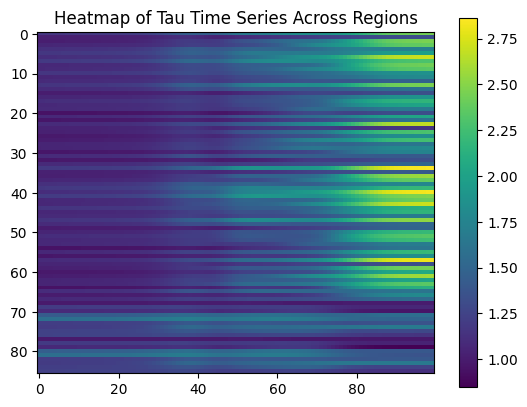

In [70]:
# Generate a heat map of ynew

# Generate heatmap
plt.imshow(tau_array, cmap='viridis', interpolation='none')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Heatmap of Tau Time Series Across Regions')
plt.show()

In [ ]:
# List of regions to exclude from further analysis due to errors in tau-PET imaging (DONT RUN FOR NOW)

regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']      
